# Demo

这是一个Neilyst回测系统V1.0版本的回测demo。

## Step 1：获取数据

In [1]:
from Neilyst import Neilyst

# 初始化币安U本位合约对象
# 如果想要对现货数据进行分析
# 将参数改为'binance'即可
# 如果需要别的交易所的数据
# 参考ccxt不同交易所的关键词即可
BTCUSDTyst = Neilyst('binanceusdm')

# 获取数据，参数含义分别为symbol，开始时间和结束时间，其中timeframe为一个可选参数，其值默认是1d，表示时间周期。
BTCUSDTyst.fetch('BTC/USDT', '2022-01-01T00:00:00Z', '2022-02-01T00:00:00Z', timeframe='1d')

# 获取的数据是一个dataframe，保存在ohlcv_data这个属性中
print(BTCUSDTyst.ohlcv_data.head())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                timestamp      open      high       low     close      volume
date                                                                         
2022-01-01  1640995200000  46210.57  47943.77  46210.55  47704.35  179433.584
2022-01-02  1641081600000  47704.35  48000.00  46605.68  47280.00  184795.093
2022-01-03  1641168000000  47280.01  47575.22  45665.40  46445.81  244781.793
2022-01-04  1641254400000  46445.80  47524.36  45445.57  45833.42  292149.750
2022-01-05  1641340800000  45833

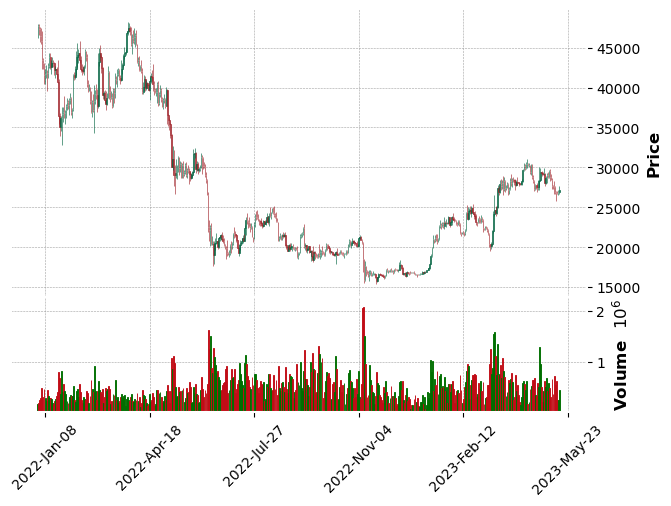

In [2]:
# 这个方法可以画出当前数据的蜡烛图

BTCUSDTyst.show_ohlcv()

## Step 2：指标构建

In [3]:
# 计算指标的方式
BTCUSDTyst.MA(20)
BTCUSDTyst.MA(60)

# 所有指标数据保存在indicators这个属性中
print(BTCUSDTyst.indicators.head())

                  MA20          MA60
date                                
2022-01-01  43289.1375  40960.614167
2022-01-02  43289.1375  40960.614167
2022-01-03  43289.1375  40960.614167
2022-01-04  43289.1375  40960.614167
2022-01-05  43289.1375  40960.614167


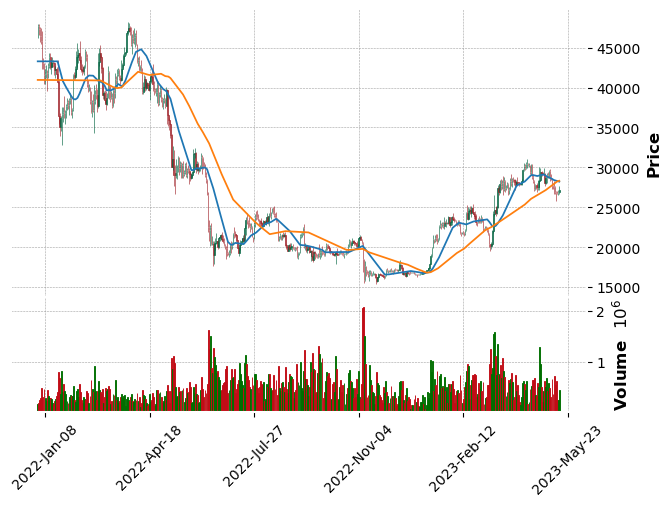

In [4]:
# 可以用如下的方式展示部分指标
BTCUSDTyst.show_indicators('MA20', 'MA60')

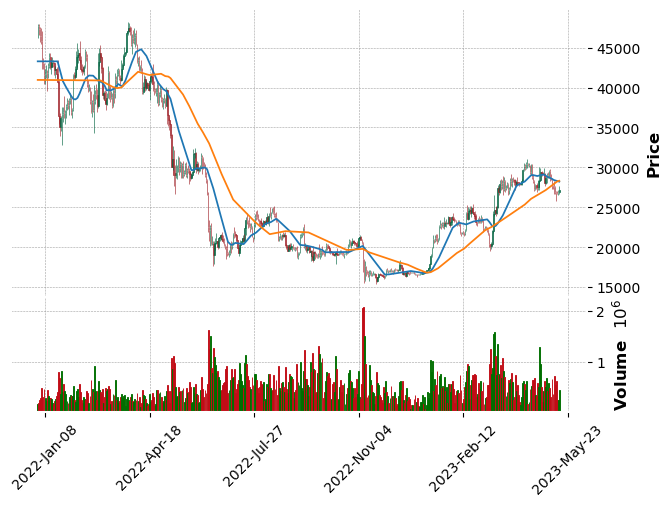

In [5]:
# 可以用如下的方式展示所有指标
BTCUSDTyst.show_all_indicators()

## Step 3：策略编写与回测

用户的策略应该写在一个class中，这个class必须有一个名为check_signal的方法，传入参数必须与我的一致。

其中:
* index的格式是timestamp：2022-01-01
* row是这样的一行：
  
| date       | timestamp     | open     | high     | low      | close    | volume     | MA20      | MA60              | pos | balance | total | entry_price |
|------------|---------------|----------|----------|----------|----------|------------|-----------|-------------------|-----|---------|-------|-------------|
| 2022-01-01 | 1640995200000 | 46210.57 | 47943.77 | 46210.55 | 47704.35 | 179433.584 | 43289.1375 | 40960.614166666666 | 0.0 | 10000.0 | 10000.0 | 0.0         |

* data参数包含了所有的row
* pos参数包含了当前的仓位

这个表中的参数前面的都展示过，后面的pos表示当前的仓位，balance表示当前可用的现金，total表示当前的总资产，entry_price表示开仓时买入的价格，是用来计算pnl的。

下文代码中展示了一个非常简单且**不挣钱**的双均线策略，用来展示这个回测引擎的用法。


In [6]:
class myStrategy:
    def __init__(self):
        self.short_window = 20
        self.long_window = 60

    def check_signal(self, index, row, data, pos):
        # 获取当前行的位置
        current_index = data.index.get_loc(index)

        # 确保有足够的数据来计算MA
        if current_index < self.long_window:
            return None  # 不足够的数据来生成信号

        # 获取前一行的数据
        previous_row = data.iloc[current_index - 1]

        current_short_ma = row[f'MA{self.short_window}']
        current_long_ma = row[f'MA{self.long_window}']
        previous_short_ma = previous_row[f'MA{self.short_window}']
        previous_long_ma = previous_row[f'MA{self.long_window}']
        current_pos = pos

        # 开多信号
        if current_pos == 0 and previous_short_ma < previous_long_ma and current_short_ma > current_long_ma:
            return ['long']
        # 开空信号
        elif current_pos == 0 and previous_short_ma > previous_long_ma and current_short_ma < current_long_ma:
            return ['short']
        # 平多信号
        elif current_pos > 0 and previous_short_ma > previous_long_ma and current_short_ma < current_long_ma:
            return ['close', 'short']
        # 平空信号
        elif current_pos < 0 and previous_short_ma < previous_long_ma and current_short_ma > current_long_ma:
            return ['close', 'long']

        return None


In [7]:
# 设定好策略以后，使用如下的方式就可以调用回测引擎。

strategy = myStrategy()
BTCUSDTyst.run_backtest(strategy)

# 策略运行完成以后，所有的数据保存在data这个属性中。
BTCUSDTyst.data.head()

ValueError: Shape of passed values is (5, 1), indices imply (5, 5)

In [ ]:
BTCUSDTyst.data.to_csv('data.csv')

In [ ]:
# 交易记录保存在trade_record中
BTCUSDTyst.trade_record

,date,signal,price,amount,pnl,0,1,2,3,4,...,0,1,2,3,4,0,1,2,3,4
0,NaN,NaN,NaN,NaN,NaN,2022-03-16,long,41107.85529,0.243226,0,...,2023-05-14,close,26900.554905,0.389077,-3.031085,2023-05-14,short,26900.554905,0.388961,0


In [ ]:
# 关于这个策略的评价指标可以使用如下方法来展示
BTCUSDTyst.evaluate()

ZeroDivisionError: division by zero

In [ ]:
import pandas as pd

a = pd.DataFrame([1, 2], columns=['a', 'b'])
a

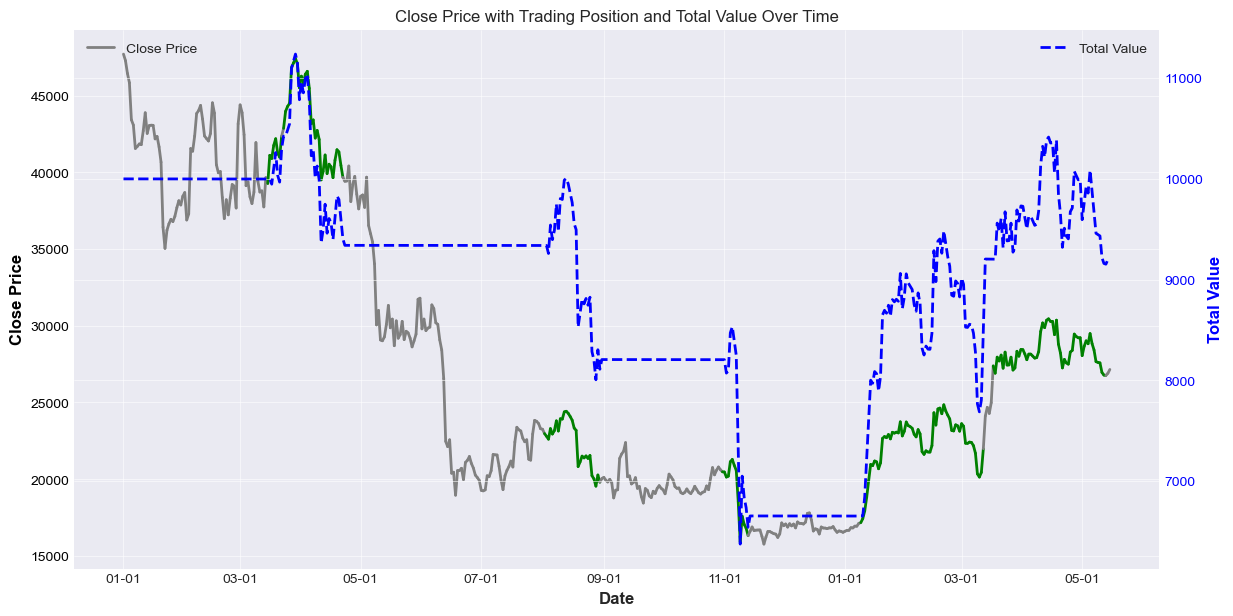

In [ ]:
# 总资产变化曲线，symbol价格曲线，和开仓曲线画在了一张图上。
BTCUSDTyst.show_pnl()